In [1]:

from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

# Set correct input and output paths (adjust if your path differs)
WORKDIR = Path("/kaggle/input/env-resilience-agent-output/env_resilience_agent")
OUTDIR = Path("/kaggle/working")
OUTDIR.mkdir(parents=True, exist_ok=True)

print("WORKDIR:", WORKDIR.exists(), WORKDIR)
print("OUTDIR:", OUTDIR)
# Load final output if present
final_json_path = OUTDIR / "final_output.json"
if not final_json_path.exists():
    # fallback: try Kaggle input final_output if saved there
    cand = WORKDIR.parent.parent / "working" / "final_output.json"
    # usually final_output.json is in /kaggle/working
print("final_output.json present in /kaggle/working:", final_json_path.exists())

WORKDIR: True /kaggle/input/env-resilience-agent-output/env_resilience_agent
OUTDIR: /kaggle/working
final_output.json present in /kaggle/working: False


In [2]:
from pathlib import Path
import pandas as pd
import json

WORKDIR = Path("/kaggle/input/env-resilience-agent-output/env_resilience_agent")
print("WORKDIR:", WORKDIR.exists())

def load_csv(f):
    p = WORKDIR/f
    if p.exists():
        print("Loaded:", f)
        return pd.read_csv(p)
    else:
        print("Missing:", f)
        return None

aqi = load_csv("aqi.csv")
aqi_hist = load_csv("aqi_history_processed.csv")
aqi_fore = load_csv("aqi_forecast.csv")
ndvi_grid = load_csv("ndvi_grid.csv")
ndvi_overall = load_csv("ndvi_overall.csv")
complaints = load_csv("complaints.csv")

print("Done.")

WORKDIR: True
Loaded: aqi.csv
Loaded: aqi_history_processed.csv
Loaded: aqi_forecast.csv
Loaded: ndvi_grid.csv
Loaded: ndvi_overall.csv
Loaded: complaints.csv
Done.


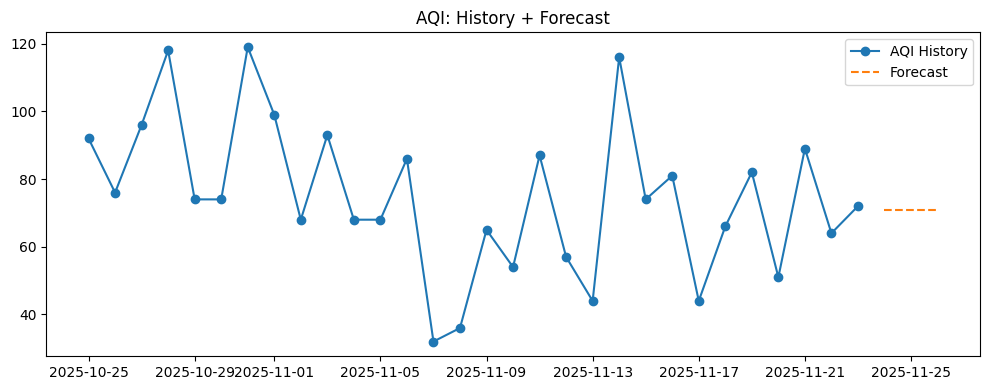

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# History
if aqi_hist is not None:
    # auto date column detection
    date_col = "date"
    for c in aqi_hist.columns:
        if "date" in c.lower() or "day" in c.lower():
            date_col = c
            break

    try:
        aqi_hist[date_col] = pd.to_datetime(aqi_hist[date_col])
        plt.plot(aqi_hist[date_col], aqi_hist.iloc[:,1], label="AQI History", marker='o')
    except:
        print("AQI history date parse error")

# Forecast
if aqi_fore is not None:
    try:
        aqi_fore['date'] = pd.to_datetime(aqi_fore['date'])
        pred_col = [c for c in aqi_fore.columns if "pred" in c.lower()][0]
        plt.plot(aqi_fore['date'], aqi_fore[pred_col], label="Forecast", linestyle="--")
    except:
        print("Forecast parse error")

plt.legend()
plt.title("AQI: History + Forecast")
plt.tight_layout()
plt.savefig("/kaggle/working/aqi_plot.png")
plt.show()

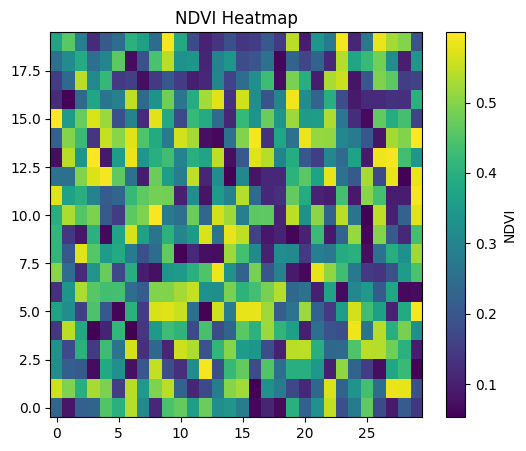

In [4]:
import numpy as np

if ndvi_grid is not None and 'lat' in ndvi_grid.columns and 'lon' in ndvi_grid.columns:
    try:
        lat_sorted = np.sort(ndvi_grid['lat'].unique())
        lon_sorted = np.sort(ndvi_grid['lon'].unique())
        heat = ndvi_grid.pivot(index='lat', columns='lon', values='ndvi').reindex(lat_sorted).reindex(columns=lon_sorted)

        plt.figure(figsize=(6,5))
        plt.imshow(heat, origin="lower", aspect="auto")
        plt.colorbar(label="NDVI")
        plt.title("NDVI Heatmap")
        plt.savefig("/kaggle/working/ndvi_heatmap.png")
        plt.show()
    except Exception as e:
        print("NDVI heatmap error:", e)
else:
    print("NDVI grid incomplete — skipping heatmap.")

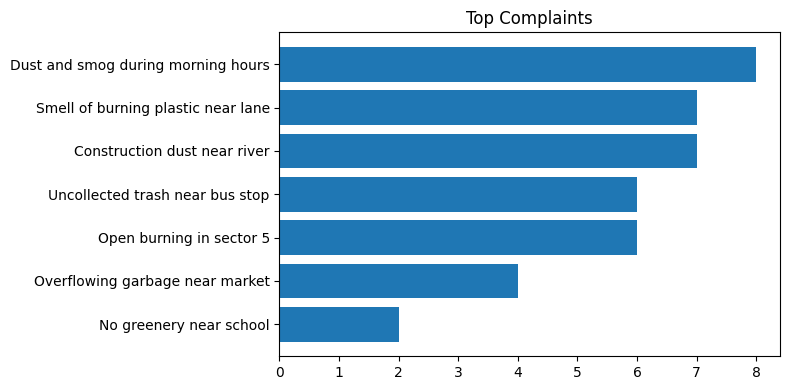

In [5]:
if complaints is not None:
    text_col = None
    for c in complaints.columns:
        if "text" in c.lower() or "complaint" in c.lower():
            text_col = c
            break

    if text_col:
        top = complaints[text_col].value_counts().head(8)

        plt.figure(figsize=(8,4))
        plt.barh(top.index[::-1], top.values[::-1])
        plt.title("Top Complaints")
        plt.tight_layout()
        plt.savefig("/kaggle/working/complaints_plot.png")
        plt.show()
    else:
        print("No complaint text column found.")
else:
    print("Complaints.csv missing")

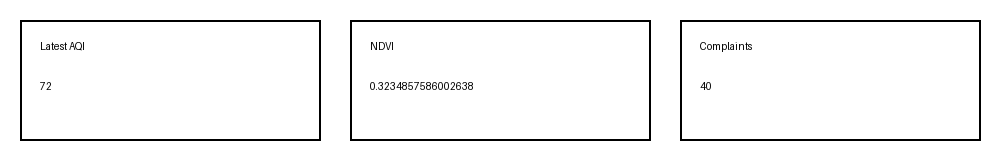

In [6]:
from PIL import Image, ImageDraw

img = Image.new("RGB", (1000,160), color="white")
d = ImageDraw.Draw(img)

def box(x, title, val):
    d.rectangle([x,20,x+300,140], outline="black", width=2)
    d.text((x+20,40), title, fill="black")
    d.text((x+20,80), str(val), fill="black")

# Safe values
latest_aqi = aqi['aqi'].iloc[-1] if aqi is not None and 'aqi' in aqi.columns else "N/A"
ndvi_val = ndvi_overall.iloc[0].values[0] if ndvi_overall is not None else "N/A"
compl_count = len(complaints) if complaints is not None else 0

box(20, "Latest AQI", latest_aqi)
box(350, "NDVI", ndvi_val)
box(680, "Complaints", compl_count)

img.save("/kaggle/working/kpi_row.png")
img

In [7]:
import matplotlib.backends.backend_pdf as pdf_backend

pdf_path = "/kaggle/working/final_report.pdf"
pdf = pdf_backend.PdfPages(pdf_path)

for img in OUTDIR.iterdir():
    if img.suffix == ".png":
        fig = plt.figure()
        plt.imshow(plt.imread(img))
        plt.axis("off")
        pdf.savefig(fig)
        plt.close()

pdf.close()

print("PDF saved at:", pdf_path)

PDF saved at: /kaggle/working/final_report.pdf


In [8]:
# Robust Cell 7 — Build report.html safely (fail-safe, checks images)
from pathlib import Path
import pandas as pd
import json, os

# Paths — adjust if your OUTDIR different
WORKDIR = Path("/kaggle/input/env-resilience-agent-output/env_resilience_agent")
OUTDIR  = Path("/kaggle/working")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Candidate image names (from Notebook-3 cells)
candidate_images = {
    "kpi": OUTDIR/"kpi_row.png",
    "aqi_plot": OUTDIR/"aqi_trend_forecast.png",
    "ndvi": OUTDIR/"ndvi_heatmap.png",
    "complaints": OUTDIR/"complaints_top.png"
}

# Load final_out if exists (optional)
final_out = {}
final_json = OUTDIR / "final_output.json"
if final_json.exists():
    try:
        final_out = json.load(open(final_json, encoding="utf8"))
    except Exception as e:
        print("Warning: couldn't load final_output.json:", e)

# Build HTML parts safely
html_parts = []
html_parts.append("<html><head><meta charset='utf-8'><title>Env Resilience Report</title></head><body style='font-family:Arial,Helvetica,sans-serif;max-width:900px;margin:20px;'>")
html_parts.append(f"<h1>Environment Resilience Agent — Report</h1>")
html_parts.append(f"<p><strong>Generated:</strong> {pd.Timestamp.now().isoformat()}</p>")

# KPI
html_parts.append("<h2>Key KPIs</h2>")
if candidate_images["kpi"].exists():
    html_parts.append(f'<img src="{candidate_images["kpi"].name}" style="max-width:100%;height:auto;">')
else:
    html_parts.append("<p><em>KPI image not available.</em></p>")

# AQI
html_parts.append("<h2>AQI: History & Forecast</h2>")
if candidate_images["aqi_plot"].exists():
    html_parts.append(f'<img src="{candidate_images["aqi_plot"].name}" style="max-width:100%;height:auto;">')
else:
    # fallback: if aqi history table exists, show short table
    try:
        aqi_path = WORKDIR/"aqi_history_processed.csv"
        if aqi_path.exists():
            df = pd.read_csv(aqi_path, parse_dates=True)
            sample_html = df.head(10).to_html(index=False)
            html_parts.append("<p><em>AQI plot missing — showing sample AQI table:</em></p>")
            html_parts.append(sample_html)
        else:
            html_parts.append("<p><em>AQI plot not available and no AQI history file found.</em></p>")
    except Exception as e:
        html_parts.append(f"<p><em>Error loading AQI sample: {e}</em></p>")

# NDVI
html_parts.append("<h2>NDVI Heatmap</h2>")
if candidate_images["ndvi"].exists():
    html_parts.append(f'<img src="{candidate_images["ndvi"].name}" style="max-width:100%;height:auto;">')
else:
    html_parts.append("<p><em>NDVI heatmap not available.</em></p>")

# Complaints
html_parts.append("<h2>Complaints Summary</h2>")
if candidate_images["complaints"].exists():
    html_parts.append(f'<img src="{candidate_images["complaints"].name}" style="max-width:100%;height:auto;">')
else:
    # fallback: show top complaint texts if available
    try:
        comp_path = WORKDIR/"complaints_summary.csv"
        if comp_path.exists():
            dfc = pd.read_csv(comp_path)
            html_parts.append("<p><em>Complaints plot missing — showing complaints summary table:</em></p>")
            html_parts.append(dfc.head(10).to_html(index=False))
        else:
            html_parts.append("<p><em>Complaints plot not available.</em></p>")
    except Exception as e:
        html_parts.append(f"<p><em>Error loading complaints summary: {e}</em></p>")

# LLM summary (if available)
html_parts.append("<h2>LLM Summary</h2>")
llm_text = final_out.get("llm_summary") if isinstance(final_out, dict) else None
if llm_text:
    # escape
    safe_text = str(llm_text).replace("<","&lt;").replace(">","&gt;")
    html_parts.append(f"<pre style='white-space:pre-wrap'>{safe_text}</pre>")
else:
    html_parts.append("<p><em>No LLM summary available.</em></p>")

# Footer
html_parts.append("<hr><p>Generated by Env-Resilience Agent — Capstone Project</p>")
html_parts.append("</body></html>")

# Write HTML to OUTDIR and ensure images are copied into OUTDIR for relative referencing
report_path = OUTDIR/"report.html"
with open(report_path, "w", encoding="utf8") as f:
    f.write("\n".join(html_parts))

# copy any existing candidate images into OUTDIR (if they were saved elsewhere)
# usually images are created in OUTDIR already; still try to copy from WORKDIR if present
from shutil import copy2
for key,p in candidate_images.items():
    # if image already exists in OUTDIR (same path), ok. If not, maybe WORKDIR has it — try copy.
    dst = OUTDIR / p.name
    if not dst.exists():
        # check if WORKDIR contains that image name
        src_in_workdir = WORKDIR / p.name
        if src_in_workdir.exists():
            try:
                copy2(src_in_workdir, dst)
            except Exception as e:
                print(f"Could not copy {src_in_workdir} -> {dst}: {e}")

print("Report written to:", report_path)
print("Files in /kaggle/working (top 50):")
for i,p in enumerate(sorted(Path("/kaggle/working").iterdir())):
    if i>50: break
    print("-", p.name)

Report written to: /kaggle/working/report.html
Files in /kaggle/working (top 50):
- __notebook__.ipynb
- aqi_plot.png
- complaints_plot.png
- final_report.pdf
- kpi_row.png
- ndvi_heatmap.png
- report.html


Search directories checked:
 - /kaggle/working
 - /kaggle/input

Total files found: 17 

#1 -> /kaggle/working/kpi_row.png  (size=4194 bytes)


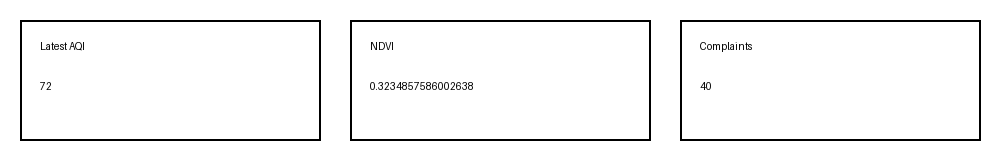

--------------------------------------------------------------------------------
#2 -> /kaggle/working/aqi_plot.png  (size=46746 bytes)


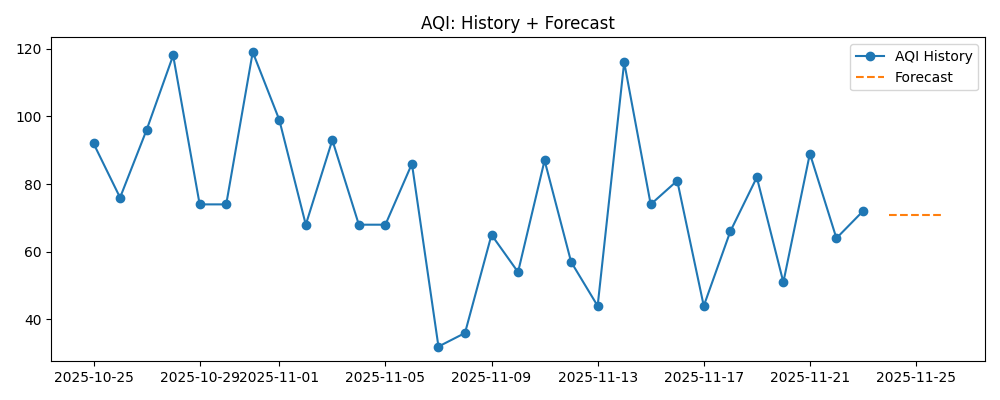

--------------------------------------------------------------------------------
#3 -> /kaggle/working/ndvi_heatmap.png  (size=20228 bytes)


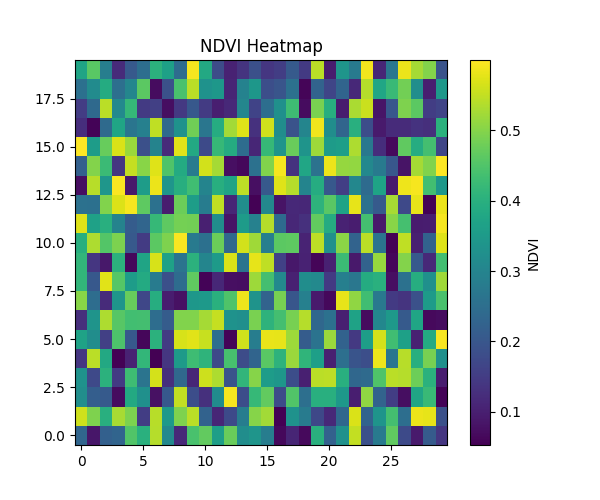

--------------------------------------------------------------------------------
#4 -> /kaggle/working/complaints_plot.png  (size=31250 bytes)


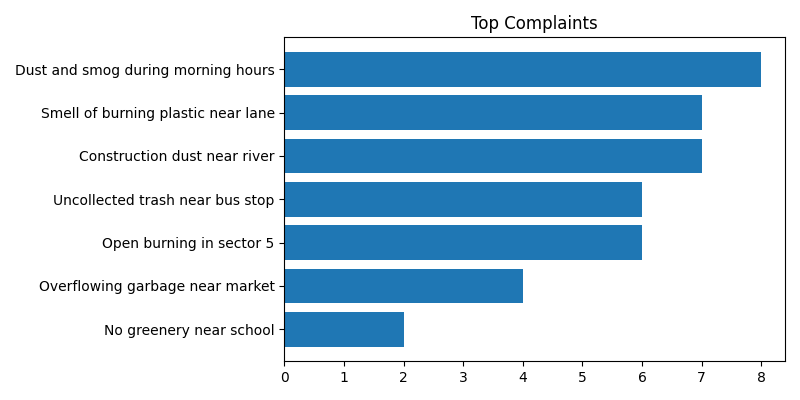

--------------------------------------------------------------------------------
#5 -> /kaggle/working/final_report.pdf  (size=82291 bytes)
PDF File:


--------------------------------------------------------------------------------
#6 -> /kaggle/working/__notebook__.ipynb  (size=175807 bytes)


--------------------------------------------------------------------------------
#7 -> /kaggle/working/report.html  (size=2689 bytes)


--------------------------------------------------------------------------------
#8 -> /kaggle/input/env-resilience-agent-output/env_resilience_agent/complaints_summary.csv  (size=199 bytes)


--------------------------------------------------------------------------------
#9 -> /kaggle/input/env-resilience-agent-output/env_resilience_agent/ndvi_grid.csv  (size=32343 bytes)


--------------------------------------------------------------------------------
#10 -> /kaggle/input/env-resilience-agent-output/env_resilience_agent/complaints.csv  (size=2828 bytes)


--------------------------------------------------------------------------------

Displayed 10 visual file(s).


In [9]:
# Clean version: No HTML embed, No IFrame, No folium inline
from pathlib import Path
from IPython.display import Image, display, HTML
import mimetypes

SEARCH_DIRS = [
    Path("/kaggle/working/final_figs"),
    Path("/kaggle/working"),
    Path("/kaggle/input")
]

files = []
for base in SEARCH_DIRS:
    if base.exists():
        for p in base.rglob("*"):
            if p.is_file():
                mime, _ = mimetypes.guess_type(str(p))
                ext = p.suffix.lower()
                files.append((str(p), ext, mime or ""))

# priority: image > pdf > others
priority = {".png":0, ".jpg":0, ".jpeg":0, ".svg":0, ".pdf":1}
files_sorted = sorted(files, key=lambda t: priority.get(t[1], 10))

print("Search directories checked:")
for d in SEARCH_DIRS:
    if d.exists():
        print(" -", d)
print("\nTotal files found:", len(files_sorted), "\n")

MAX_SHOW = 10
shown = 0

for path, ext, mime in files_sorted:
    if shown >= MAX_SHOW:
        break

    size = Path(path).stat().st_size
    print(f"#{shown+1} -> {path}  (size={size} bytes)")

    try:
        if ext in (".png", ".jpg", ".jpeg", ".svg"):
            # show image
            display(Image(filename=path, width=800))

        elif ext == ".pdf":
            # show link only
            print("PDF File:")
            display(HTML(f'<a href="{path}" target="_blank">Open PDF: {Path(path).name}</a>'))

        else:
            # show link for other files
            display(HTML(f'<a href="{path}" target="_blank">Open file: {Path(path).name}</a>'))

    except Exception as e:
        print("Could not display:", e)

    print("-"*80)
    shown += 1

if shown == 0:
    print("⚠ No PNG/JPG/SVG/PDF files found. Run your plotting cells again.")
else:
    print(f"\nDisplayed {shown} visual file(s).")

In [10]:
# Cell 8 - show report file location
print("Report saved at:", OUTDIR/"report.html")
# In Kaggle notebook UI you can click 'Files' tab and open report.html

Report saved at: /kaggle/working/report.html
